# Motivation
One of the biggest challenges faced by students today is the balance between understanding & recall. Usually, when you learn something new, you have to not only understand that material but also take it down somewhere for future review. Unfortunately, the current golden standard (taking notes), just does not cut it. Usually, during lectures, it is very difficult to take notes & pay attention to the problem being faced hence affecting productivity. Introducing our solution, a comprehensive Artificial Intelligence that focuses on taking notes for you while you pay attention to your lecture. It reduces the element of distraction from your side.

# Proposed Algorithm:


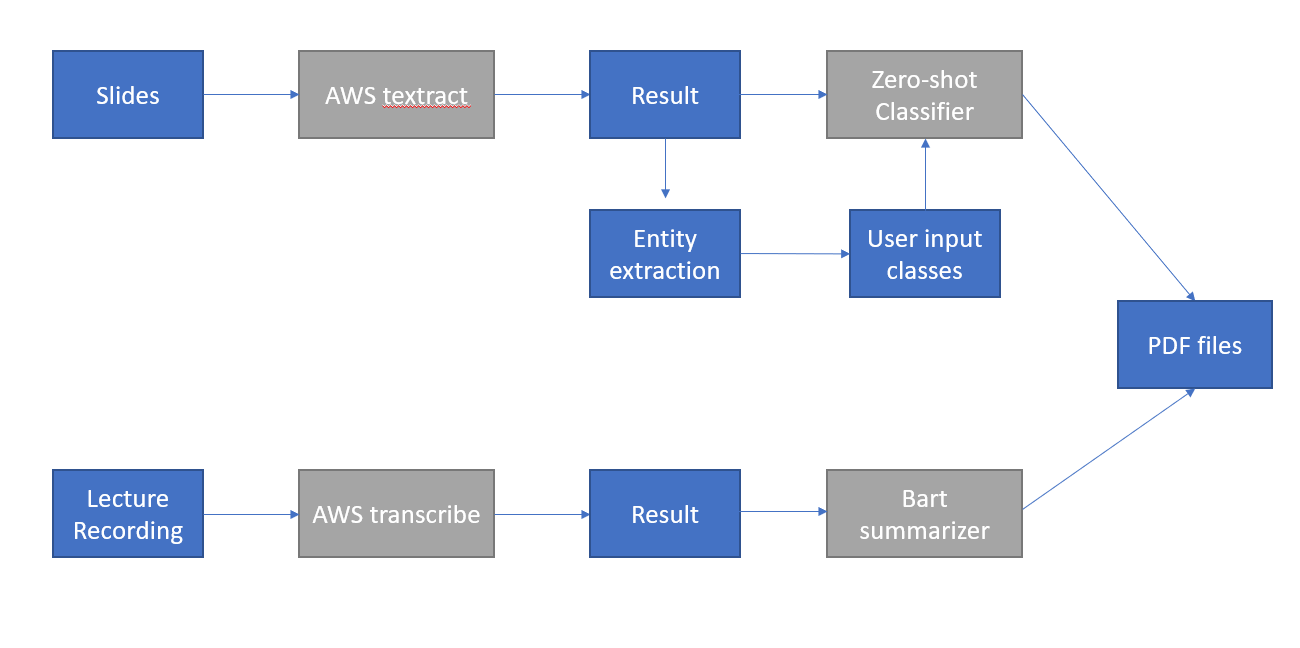

The flowchart below provides an overall architecture for solving the problem at hand.

Firstly, lecture slides and lecture recording are provided. **AWS Textract** is used to extract text from the slides and **AWS Transcribe** is used to extract text from the recording.
Using the text extracted from the slides, we will use **AWS Entity Extraction** to extract the entities from the result. I will get back on what we will use this entities for. Next we will use **Zero-Shot classifier** to classify the each individual slides. How **zero-shot classifier** works is that user must enter the classes they want to classify the data into. This is where the result of the entities extraction come into play. We will use the result from the entity extraction as a suggestion or recommendation for zero-shot classification classes. The user can pick the entity extraction result or enter they own classes. The output after zero-shot classifier will each indiviual slide with the classification result. We will can store all the slides with the same class into a PDF file for the user to upload to their own note taking app. 
**Disclaimer: input classes must be related to the topic of the lecture**.

The transcribe result will be passed to a summarizer to summarize the result. We will be using **Bart** and the result will be store in a pdf together with the orginial lecture transcribe.



## Importing the Essential Libraries

In [46]:
!pip install fpdf
!pip install ipywidgets==7.0.0 --quiet


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [47]:
import time
import boto3
import json
from sagemaker import get_execution_role, image_uris, model_uris, script_uris, hyperparameters
from sagemaker.huggingface import HuggingFaceModel 
import pickle
from sagemaker.serverless import ServerlessInferenceConfig
import sagemaker
from fpdf import FPDF
from sagemaker.session import Session
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base

In [48]:
# Getting the execution role
role = get_execution_role()

## Using **Detect Document Text** Library to convert jpeg's of slides into texts :

In [51]:
# Initializing the list of file names
list_of_file_names = []

# Extracting all the files in the directory

import boto3

s3_client = boto3.client('s3')

objects = s3_client.list_objects_v2(Bucket='neuralninjasresource')

# Adding the file names into the list
for obj in objects['Contents']:
    list_of_file_names.append(obj['Key'])


list_of_file_names = list_of_file_names[15:24]

In [52]:
list_of_file_names

['ImagesOfSlides/Machine Learning Infographics by Slidesgo/Slide (1).JPG',
 'ImagesOfSlides/Machine Learning Infographics by Slidesgo/Slide (10).JPG',
 'ImagesOfSlides/Machine Learning Infographics by Slidesgo/Slide (11).JPG',
 'ImagesOfSlides/Machine Learning Infographics by Slidesgo/Slide (2).JPG',
 'ImagesOfSlides/Machine Learning Infographics by Slidesgo/Slide (3).JPG',
 'ImagesOfSlides/Machine Learning Infographics by Slidesgo/Slide (4).JPG',
 'ImagesOfSlides/Machine Learning Infographics by Slidesgo/Slide (5).JPG',
 'ImagesOfSlides/Machine Learning Infographics by Slidesgo/Slide (6).JPG',
 'ImagesOfSlides/Machine Learning Infographics by Slidesgo/Slide (7).JPG']

In [53]:
# Initializing the list of slides
list_of_slides = []

# Initializing the variables
s3BucketName = 'neuralninjasresource'
textractmodule = boto3.client('textract')

# Looping through the files to generate the text
for i in list_of_file_names:
    # Generating the response
    response = textractmodule.detect_document_text(
        Document={
            'S3Object':{
                'Bucket':s3BucketName,
                'Name': i 
            }
        })
    list_of_text_per_slide = []
    # Initializing the number of slides per slide
    for item in response['Blocks']:
        if item['BlockType'] == 'LINE':
            list_of_text_per_slide.append(item['Text'])
    
    list_of_slides.append(list_of_text_per_slide)

## Extracting text from the Lecture Speech using pretrained libraries from AWS

In [54]:
### Amazon Transcribe Example

def transcribe_file(job_name, file_uri, transcribe_client):
    transcribe_client.start_transcription_job(
        TranscriptionJobName = job_name,
        Media = {
            'MediaFileUri': file_uri
        },
        MediaFormat = 'mp3',
        LanguageCode = 'en-US',
        OutputBucketName = 'neuralninjasresource'
    )

    max_tries = 60
    while max_tries > 0:
        max_tries -= 1
        job = transcribe_client.get_transcription_job(TranscriptionJobName = job_name)
        job_status = job['TranscriptionJob']['TranscriptionJobStatus']
        if job_status in ['COMPLETED', 'FAILED']:
            print(f"Job {job_name} is {job_status}.")
            if job_status == 'COMPLETED':
                print(
                    f"Download the transcript from\n"
                    f"\t{job['TranscriptionJob']['Transcript']['TranscriptFileUri']}.")
                return job['TranscriptionJob']['Transcript']['TranscriptFileUri']

                    
            break
        else:
            print(f"Waiting for {job_name}. Current status is {job_status}.")
        time.sleep(10)

    ### Need to add audio scripts to s3 buckets.
transcribe_client = boto3.client('transcribe', region_name = 'ap-southeast-1')
file_uri = 's3://neuralninjasresource/audiorecordings/lecture_speech.mp3'
url = transcribe_file('Example-job1312', file_uri, transcribe_client)

Waiting for Example-job1312. Current status is IN_PROGRESS.
Waiting for Example-job1312. Current status is IN_PROGRESS.
Waiting for Example-job1312. Current status is IN_PROGRESS.
Job Example-job1312 is COMPLETED.
Download the transcript from
	https://s3.ap-southeast-1.amazonaws.com/neuralninjasresource/Example-job1312.json.


In [57]:
# Establishing a connection to the s3 file
conn = boto3.client('s3')
contents = conn.list_objects(Bucket="neuralninjasresource", Prefix="audiorecordings")['Contents']
for f in contents:
    print(f['Key'])
    
# Getting the file from the bucket
my_bucket = 'neuralninjasresource'
my_file = 'Example-job192.json'
s3client = boto3.client('s3')
obj = s3client.get_object(Bucket=my_bucket, Key=my_file)
transcribed_text = json.loads(obj['Body'].read())['results']['transcripts'][0]['transcript']

transcribed_text

audiorecordings/
audiorecordings/.write_access_check_file.temp
audiorecordings/Example-job18.json
audiorecordings/Lecture Audio.mp3
audiorecordings/asrOutput.json
audiorecordings/lecture_speech.mp3


'Filtering, mobile banking risk assessment and social networks. So if you visualize a machine learning layer as a layer of onions, you can put it first. Deep learning, machine learning and artificial has progressed started from simple algorithms in the 19 fifties to deep learning popularity in the 2000 tens. However, machine learning does have some disadvantages like continuous improvement time and resources. Machine learning can also be used in image voice and optical recognition. The different types of machine learning models include supervised unsupervised, semi supervised time and resources. Machine learning can also be used in image voice and optical recognition. The different types of machine learning models include supervised unsupervised, semi supervised collecting data, prepare the data train a model, evaluate the model improve. An example of machine learning classification include tweet feature, engineering classification and output chatbots. Systems decision support include 

## Summarization

In [60]:
sagemaker_session = Session()
aws_role = sagemaker_session.get_caller_identity_arn()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

model_id, model_version = "huggingface-summarization-distilbart-xsum-1-1", "*"

endpoint_name = name_from_base(f"jumpstart-example-{model_id}")

# inference_instance_type = "ml.t3.medium"
inference_instance_type = "ml.g4dn.2xlarge"


# Retrieve the inference docker container uri. This is the base HuggingFace container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# Retrieve the inference script uri. This includes all dependencies and scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)


# Retrieve the model uri. This includes the pre-trained model and parameters.
model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)


# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    model_data=model_uri,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
)

# deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = text.encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return summary text."""

    model_predictions = json.loads(query_response)
    translation_text = model_predictions["summary_text"]
    return translation_text

print("done")

KeyboardInterrupt: 

## The summary

In [ ]:
newline, bold, unbold = "\n", "\033[1m", "\033[0m"

input_text = transcribed_text
query_response = query(model_predictor, input_text)

summary_text = parse_response(query_response)
print(f"Input text: {input_text}{newline}" f"Summary text: {bold}{summary_text}{unbold}{newline}")

## Using AWS to get important tags from the lectures to get the list of tags to make our notes more intuitive.

In [62]:
# Initializing the client
client = boto3.client('comprehend')

# Converting a list of lists into one list
text_of_slides_concatenated = []
for slide in list_of_slides:
    for i in range(len(slide)):
        text_of_slides_concatenated.append(slide[i])

# Converting the list of tags into a list of concatentated strings
text_of_slides_concatenated = [" ".join(map(str, text_of_slides_concatenated))]

# Generating tags from lecture slides
image_to_text_tags = client.batch_detect_entities(
    TextList=text_of_slides_concatenated, LanguageCode="en")


# Tags from Lecture speech
speech_to_text_tags = client.batch_detect_entities(
    TextList=[transcribed_text], LanguageCode="en")


In [63]:
# Initializing the list of tags for the Lecture slides
list_of_tags_image_to_text = []

# Getting the list of tags from the Lecture slides
for i in range(len(image_to_text_tags['ResultList'])):
    for j in range(len(image_to_text_tags['ResultList'][i]['Entities'])):
        if (image_to_text_tags['ResultList'][i]['Entities'][j]['Type'] != "QUANTITY"): # Include all tags other than quantity
            list_of_tags_image_to_text.append(image_to_text_tags['ResultList'][i]['Entities'][j]['Text'])

# Removing Duplicates
list_of_tags_image_to_text = list(dict.fromkeys(list_of_tags_image_to_text))

In [64]:
# Initializing the list of tags for the Lecture speech
list_of_tags_speech_to_text = []
# image_to_text_tags['ResultList'][0]['Entities'][2]['Text']

# Getting the list of tags from the Lecture slides
for i in range(len(speech_to_text_tags['ResultList'])):
    for j in range(len(speech_to_text_tags['ResultList'][i]['Entities'])):
        if (speech_to_text_tags['ResultList'][i]['Entities'][j]['Type'] != "QUANTITY"): # Include all tags other than quantity
            list_of_tags_speech_to_text.append(speech_to_text_tags['ResultList'][i]['Entities'][j]['Text'])

# Removing Duplicates
list_of_tags_speech_to_text = list(dict.fromkeys(list_of_tags_speech_to_text))

## Implementing Zero-Shot Classification to improve search results.

In [65]:
hub_v1 = {
	'HF_MODEL_ID':'facebook/bart-large-mnli',
	'HF_TASK':'zero-shot-classification'
}
role = sagemaker.get_execution_role()

In [66]:
huggingface_model = HuggingFaceModel(
	transformers_version='4.17.0',
	pytorch_version='1.10.2',
	py_version='py38',
	env=hub_v1,
	role=role, 
)
serverless_config_v1 = ServerlessInferenceConfig(
    memory_size_in_mb=4096, max_concurrency=10,
)

# deploy the endpoint endpoint
predictor_v1 = huggingface_model.deploy(
    serverless_inference_config=serverless_config_v1
)



-----!

### Implementing the Zero-Shot Classification for the Lecture Transcript & Lecture Slides

In [67]:
list_of_tags_speech_to_text,list_of_tags_image_to_text

(['19 fifties', '2000 tens', 'tomorrow'],
 ['01 02 03 04',
  '1950s',
  '1960s',
  '1970s',
  '1980s',
  'Mercury',
  'Jupiter',
  'Venus',
  'Sun',
  '05 06 07',
  '1990s',
  '2000s',
  '2010s',
  'Earth',
  'Ceres',
  'Mars',
  '03',
  '04',
  'Pluto',
  'Bayesian',
  '01',
  '02',
  'Neptune',
  '05',
  '06'])

In [28]:
# Getting the input variables
zero_shot_filters = []
condition = "j"

# Looping through to get the filters
while condition != "n":
    curr_condition = input("Type the Filter: ")
    zero_shot_filters.append(curr_condition)
    condition = input("Press any key to add more, else, type something n")
    condition = condition.lower()

zero_shot_filters

Type the Filter:  Artifical Intelligence
Press any key to add more, else, type something n y
Type the Filter:  Data
Press any key to add more, else, type something n y
Type the Filter:  Earth
Press any key to add more, else, type something n n


['Artifical Intelligence', 'Data', 'Earth']

In [69]:
# Getting the zero-shot filters for the Lecture speech
speech_zero_shot = predictor_v1.predict({
	'inputs': transcribed_text,
    "parameters":{'candidate_labels' : zero_shot_filters}
})

In [70]:
# Getting the zero-shot filters for the Lecture slides
slides_zero_shot = []
for i in list_of_slides:
    slides_zero_shot.append(predictor_v1.predict({
        'inputs': " ".join(i),
        "parameters":{'candidate_labels' : zero_shot_filters}
    }))

### Function to return the slides with the highest probability value

In [71]:
def get_slide_index(zero_shot_matrix, topics):
    
    # Initializing an empty list
    returning_list = []
    
    # Looping through to get the index
    # for i in range(len(zero_shot_matrix)):
    #     # Looping through each slide
    #     for j in range(len(zero_shot_matrix[i])):
    #         scores = zero_shot_matrix[i]['scores']
    #         # Looping through the scores
    #         for k in range(len(scores)):
    #             # If the score value exceeds the treshold, add it in the list
    #             if scores[k] >= prob_treshold:
    #                 returning_list.append({zero_shot_matrix[i]['labels'][k]: i+1})
    for topic in topics:
        topic_list = []
        for i,result in enumerate(zero_shot_matrix):
            if result['labels'][0] == topic:
                topic_list.append((i + 1,result['sequence']))
        returning_list.append(topic_list)
        
    return returning_list


#### Getting the slide index which matches the search

In [72]:

results = get_slide_index(slides_zero_shot, zero_shot_filters)

    

# Converting the processed data to a PDF document

In [77]:
def generatePDF(topics, list_of_texts):
    pdf = FPDF()
    pdf.set_font("Arial", size=12)
    for topic, result in zip(topics, list_of_texts):
        pdf = FPDF()
        pdf.add_page()
        pdf.set_font("Arial", size=15)
        for i in result:
                pdf.set_font("Arial", size=12)
                text = 'Slide ' +str(i[0]) + ' and here is the text:\n' + i[1]
                pdf.multi_cell(0, 5, text, 0, 1)
                pdf.cell(200, 10, txt = f" ", ln = 2, align = 'L')
        pdf.output(topic+".pdf") 

In [78]:
generatePDF(zero_shot_filters, results)

In [79]:
def generateLecturePDF(transcribedText, summarizedText):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", style="B", size=20)
    pdf.cell(180, 10, txt = "Lecture Transcript", ln = 1, align = 'L', border=0)
    pdf.cell(200, 10, txt = f" ", ln = 2, align = 'L')
    pdf.cell(200, 10, txt = f" ", ln = 2, align = 'L')
    pdf.set_font("Arial", size=12)
    pdf.multi_cell(0, 5, transcribedText, 0, 1)
    
    
    pdf.add_page()
    pdf.set_font("Arial", style="B", size=20)
    pdf.cell(180, 10, txt = "Summarized Transcript", ln = 1, align = 'L', border=0)
    pdf.cell(200, 10, txt = f" ", ln = 2, align = 'L')
    pdf.cell(200, 10, txt = f" ", ln = 2, align = 'L')
    pdf.set_font("Arial", size=12)
    pdf.multi_cell(0, 5, summarizedText, 0, 1)
    
    
    pdf.output("lecture_transcribe.pdf") 

In [80]:
generateLecturePDF(transcribed_text, summary_text)

![image.png](attachment:2807c02b-5b4a-47e3-92bb-71694fc68445.png)

Firstly, 2 inputs are provided, one is the text from the slides derived from the library **detect_document_text**  and the other is the lecture transcript derived using the 
**get_transcription_job** library. After these inputs have been processed, the one from the lecture slides is split into 3 branches. The first branch is fed into a Zero-shot classifier which can later be used to search-up notes on the fly and provide the slides found. The second one is fed into the **batch_detect_entities** library from AWS to derive import tags that can be used when generating the pdf of notes. The first branch is also fed into the PDF summary block to generate notes. This will effectively generate a pdf of all the notes and texts seen in the Lecture slides and would provide easier ways to search them. Moreover, it would provide a much better recommendation of the terms to take note of in the lecture slides. The text generated from a speech also undergoes the generation of tags and the zero-shot classifier, to help it detect what words are most likely to be in the lecture. This text is also summarized by the **BART** architecture to give a synopsis of the lecture speech. All of this is also combined into the pdf as a separate page to help students gain a better understanding of what happened in the lecture during that day.